<a href="https://colab.research.google.com/github/saritmaitra/BacktestingTradingStrategy/blob/main/oscillator_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install pyforest
from pyforest import *
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import datetime, pickle, copy, warnings
from pandas import DataFrame, concat
import seaborn
import glob
import pandas.testing as tm
from functools import reduce
from pandas import DataFrame, merge, concat
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Parallel, delayed
import seaborn as sns
import time
from sklearn.preprocessing import MaxAbsScaler
import scipy.linalg
import decimal
!pip install scikit-plot
import scikitplot
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.ticker as mtick
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport
from sklearn.decomposition import PCA, KernelPCA
from numpy import where, meshgrid, arange, hstack
from mlxtend.plotting import plot_decision_regions
from sklearn.manifold import TSNE
from sklearn.decomposition import MiniBatchDictionaryLearning
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.express as px
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedStratifiedKFold, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV,SelectPercentile,mutual_info_classif, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from numpy import mean, std
!pip install tscv
!pip install termcolor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
def SPFutures():
  df = pd.read_csv("July_Futures_15min.csv")
  df.set_index('timestamp', inplace=True)
  df.sort_index(ascending=True, inplace=True)
  df.index = pd.to_datetime(df.index)
  df = df[df['volume'] > 0]
  df.sort_index(ascending=True, inplace=True) # soring ascending order
  df.drop_duplicates(inplace=True) # dropping duplicates if any
  df.fillna(method='pad', inplace=True) # filling NaN values using bcak-fill method
  return (df)

df = SPFutures()
print(df.head())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                        es_close      es_open      es_high       es_low      volume
timestamp                                                                          
2020-07-01 00:00:00  3081.169643  3081.116071  3081.660714  3080.625000  147.857143
2020-07-01 00:15:00  3081.633333  3081.533333  3082.000000  3081.158333   72.133333
2020-07-01 00:30:00  3084.941667  3084.741667  3085.308333  3084.391667   85.733333
2020-07-01 00:45:00  3084.750000  3084.850000  3085.191667  3084.366667   69.400000
2020-07-01 01:00:00  3085.016667  3084.991667  3085.541667  3084.425000   96.133333


In [54]:
d = df.copy()
# Create the "L14" column in the DataFrame
d['L14'] = d['es_low'].rolling(window=14).min()
#Create the "H14" column in the DataFrame
d['H14'] = d['es_high'].rolling(window=14).max()
#Create the "%K" column in the DataFrame
d['%K'] = 100*((d['es_close'] - d['L14']) / (d['H14'] - d['L14']) )
#Create the "%D" column in the DataFrame
d['%D'] = d['%K'].rolling(window=3).mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

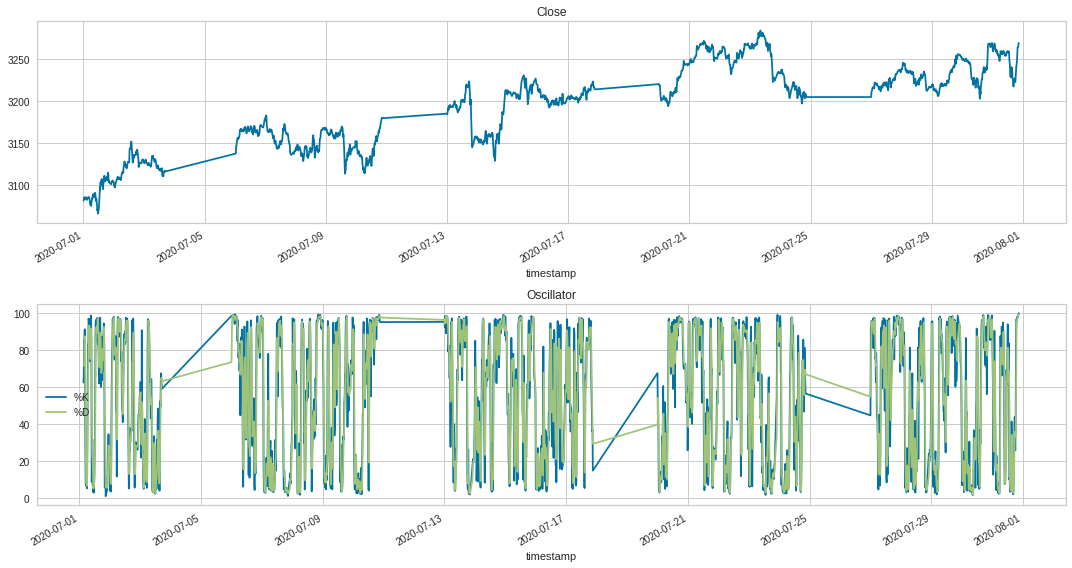

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(15,8))
d['es_close'].plot(ax=axes[0]); axes[0].set_title('Close')
d[['%K','%D']].plot(ax=axes[1]); axes[1].set_title('Oscillator')
plt.tight_layout()
plt.show()


In [56]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
d['enter_sell'] = ((d['%K'] < d['%D']) & (d['%K'].shift(1) > d['%D'].shift(1))) & (d['%D'] > 75) 
#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
d['exit_sell'] = ((d['%K'] > d['%D']) & (d['%K'].shift(1) < d['%D'].shift(1))) 
#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
d['short'] = np.nan 
d.loc[d['enter_sell'],'short'] = -1 
d.loc[d['exit_sell'],'short'] = 0 
#Set initial position on day 1 to flat 
d['short'][0] = 0 
#Forward fill the position column to represent the holding of positions through time 
d['short'] = d['short'].fillna(method='pad') 
#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
d['enter_buy'] = ((d['%K'] > d['%D']) & (d['%K'].shift(1) < d['%D'].shift(1))) & (d['%D'] < 25) 
#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
d['exit_buy'] = ((d['%K'] < d['%D']) & (d['%K'].shift(1) > d['%D'].shift(1))) 
#create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
d['long'] = np.nan  
d.loc[d['enter_buy'],'long'] = 1  
d.loc[d['exit_buy'],'long'] = 0  
#Set initial position on day 1 to flat 
d['long'][0] = 0  
#Forward fill the position column to represent the holding of positions through time 
d['long'] = d['long'].fillna(method='pad') 
#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
d['Position'] = d['long'] + d['short']

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/pyforest/__init__.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/pyforest/__init__.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



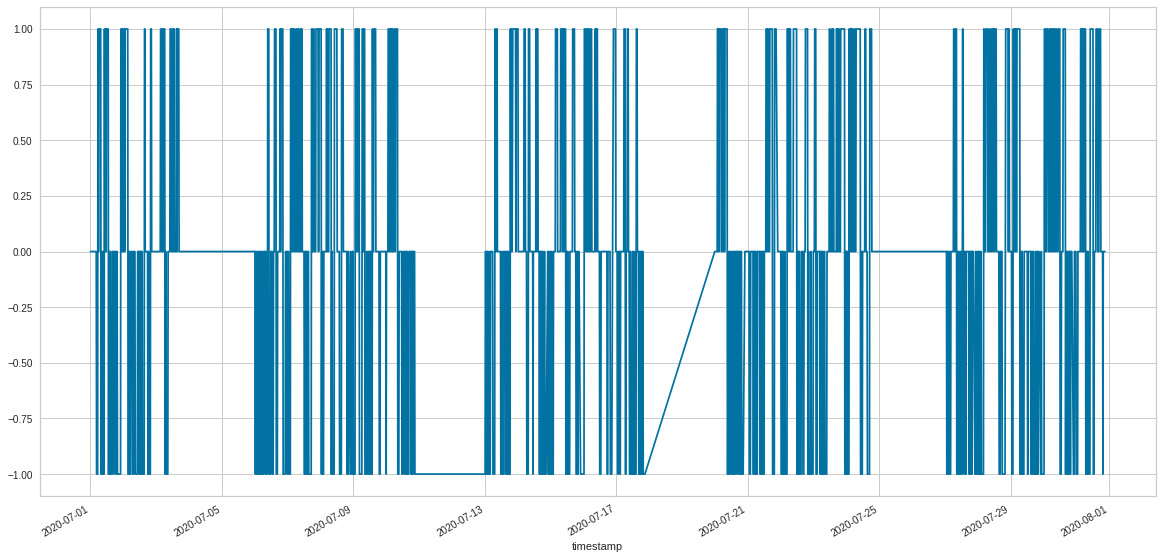

In [57]:
d['Position'].plot(figsize=(20,10))

<IPython.core.display.Javascript object>

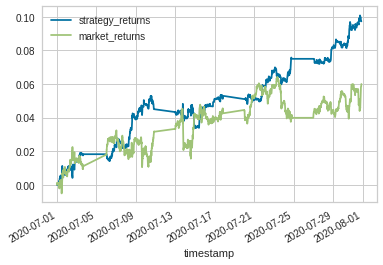

In [58]:
#Set up a column holding the daily Apple returns
d['market_returns'] = d['es_close'].pct_change()
#Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
#of business the previous day
d['strategy_returns'] = d['market_returns'] * d['Position'].shift(1)
#Finally plot the strategy returns versus Apple returns
d[['strategy_returns','market_returns']].cumsum().plot()
plt.show()

In [59]:
import statistics as stats
import math as math

print("@Sarit:")
# Variables/constants for EMA Calculation:
fastPeriod = 10 # Static time period parameter for the fast EMA
fastSmooth = 2 / (fastPeriod + 1) # Static smoothing factor parameter for fast EMA
fastEma = 0
fastEma_val = [] # we will hold fast EMA values for visualization purposes

slowPeriod = 40 # Static time period parameter for slow EMA
slowSmooth = 2 / (slowPeriod + 1) # Static smoothing factor parameter for slow EMA
slowEma = 0
slowEma_val = [] # we will hold slow EMA values for visualization purposes

poValues = [] # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buyPrice = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sellPrice = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sumPrice_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sumPrice_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
po_buyEnter = -10 # APO trading signal value below which to enter buy-orders/long-position
po_sellEnter = 10 # APO trading signal value above which to enter sell-orders/short-position
min_price_movement_from_last_trade = 10 # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
num_stocks_per_trade = 10 # Number of shares to buy/sell on every trade
min_profit_to_close = 10 * num_stocks_per_trade # Minimum Open/Unrealized profit at which to close positions and lock profits

# Constants/variables that are used to compute standard deviation as a volatility measure
maPeriods = 20 # look back period
priceHistory = [] # history of prices

close = df['es_close']
for close_price in close:
    priceHistory.append(close_price)
    if len(priceHistory) > maPeriods: # we track at most 'time_period' number of prices
        del (priceHistory[0])

    sma = stats.mean(priceHistory)
    variance = 0 # variance is square of standard deviation
    for histPrice in priceHistory:
        variance = variance + ((histPrice - sma) ** 2)

    stdev = math.sqrt(variance / len(priceHistory))
    stdev_factor = stdev/15
    if stdev_factor == 0:
        stdev_factor = 1

    # This section updates fast and slow EMA and computes APO trading signal
    if (fastEma == 0): # first observation
        fastEma = close_price
        slowEma = close_price
    else:
        fastEma = (close_price - fastEma) * fastSmooth * stdev_factor + fastEma
        slowEma = (close_price - slowEma) * slowSmooth * stdev_factor + slowEma

    fastEma_val.append(fastEma)
    slowEma_val.append(slowEma)

    po = fastEma - slowEma
    poValues.append(po)

    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
    if ((po > po_sellEnter * stdev_factor and abs(close_price - last_sellPrice) > min_price_movement_from_last_trade * stdev_factor) 
        # APO above sell entry threshold, we should sell
        or
        (position > 0 and (po >= 0 or open_pnl > min_profit_to_close / stdev_factor))): # long from -ve APO and APO has gone positive or position is profitable, sell to close position
        orders.append(-1) # mark the sell trade
        last_sellPrice = close_price
        position -= num_stocks_per_trade # reduce position by the size of this trade
        sell_sumPrice_qty += (close_price * num_stocks_per_trade) # update vwap sell-price
        sell_sum_qty += num_stocks_per_trade
        print( "SELL ", num_stocks_per_trade, " @ ", close_price, "Position => ", position )

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
    elif ((po < po_buyEnter * stdev_factor and abs(close_price - last_buyPrice) > \
           min_price_movement_from_last_trade * stdev_factor) # APO below buy entry threshold, we should buy
          or
          (position < 0 and (po <= 0 or open_pnl > min_profit_to_close / stdev_factor))): # short from +ve APO and APO has gone negative or position is profitable, buy to close position
        orders.append(+1) # mark the buy trade
        last_buyPrice = close_price
        position += num_stocks_per_trade # increase position by the size of this trade
        buy_sumPrice_qty += (close_price * num_stocks_per_trade) # update the vwap buy-price
        buy_sum_qty += num_stocks_per_trade
        print( "BUY ", num_stocks_per_trade, " @ ", close_price, "POSITION: ", position ); print()
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0: # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sumPrice_qty/sell_sum_qty - buy_sumPrice_qty/buy_sum_qty)
        
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sumPrice_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (sell_sumPrice_qty/sell_sum_qty - buy_sumPrice_qty/buy_sum_qty)
    
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sumPrice_qty/sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sumPrice_qty - buy_sumPrice_qty)
        buy_sumPrice_qty = 0
        buy_sum_qty = 0
        sell_sumPrice_qty = 0
        sell_sum_qty = 0
        last_buyPrice = 0
        last_sellPrice = 0

    print( "Open/PnL-> ", open_pnl, " Closed/PnL-> ", closed_pnl, " Total/PnL-> ", (open_pnl + closed_pnl) );
    pnls.append(closed_pnl + open_pnl)


@Sarit:
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0
Open/

In [60]:
data = df.copy()

# preparing the dataframe from the trading strategy results and visualizes the results
data = data.assign(closePrice = pd.Series(close, index =df.index))
data = data.assign(short = pd.Series(fastEma_val, index = df.index))
data = data.assign(long = pd.Series(slowEma_val, index = df.index))
data = data.assign(priceOs = pd.Series(poValues, index = df.index))
data = data.assign(trades = pd.Series(orders, index = data.index))
data = data.assign(position = pd.Series(positions, index = data.index))
data = data.assign(pnl = pd.Series(pnls, index=data.index))

data = data[['closePrice','short','long','priceOs','trades','position','pnl']]

data.head(2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,closePrice,short,long,priceOs,trades,position,pnl
timestamp,,,,,,,
2020-07-01 00:00:00,3081.169643,3081.169643,3081.169643,0.000000,0,0,0.0
2020-07-01 00:15:00,3081.633333,3081.170946,3081.169992,0.000953,0,0,0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

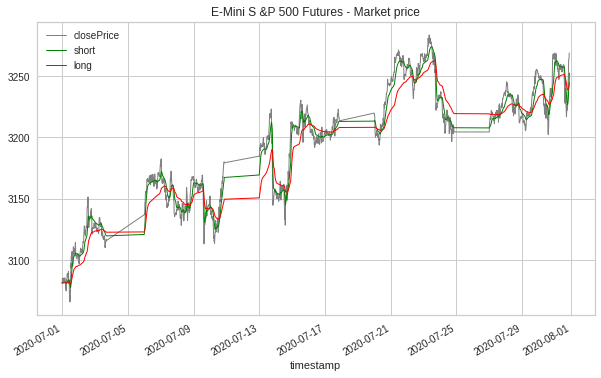

In [61]:
plt.figure(figsize = (10, 6))
data['closePrice'].plot(color = 'gray',lw = 1., legend=True)
data['short'].plot(color ='green', lw = 1., legend=True)
data['long'].plot(color ='red', lw = 1., legend=True)
plt.title("E-Mini S &P 500 Futures - Market price")
plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

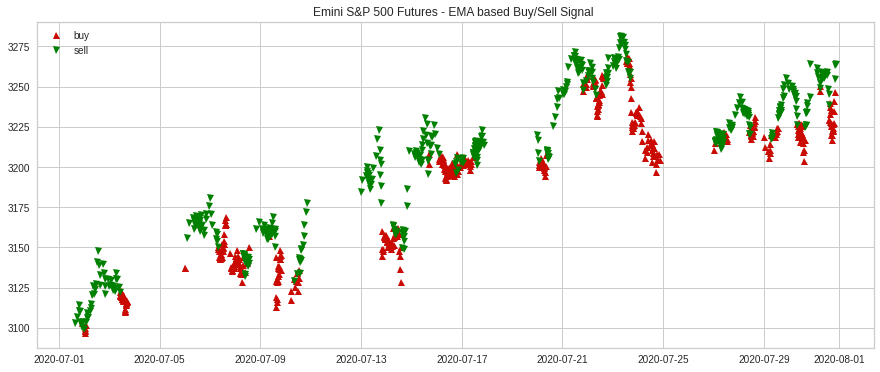

In [62]:
plt.figure(figsize = (15, 6))
plt.plot(data.loc[data.trades == 1 ].index, 
         data.closePrice[data.trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[data.trades == -1 ].index, 
         data.closePrice[data.trades == -1 ], color='green', lw=0, marker='v', markersize=7, label='sell')
plt.legend(loc = 'upper left')
plt.title('Emini S&P 500 Futures - EMA based Buy/Sell Signal ')
plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

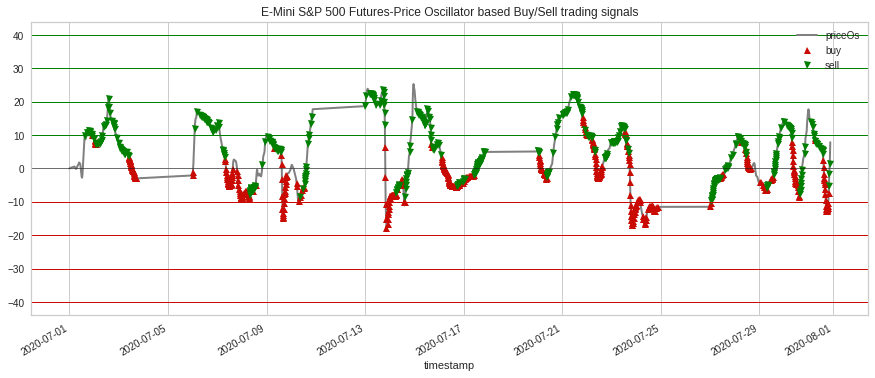

In [63]:
plt.figure(figsize = (15, 6))
data['priceOs'].plot(color='gray', lw=2., legend=True)
plt.plot(data.loc[data.trades == 1 ].index, 
         data.priceOs[data.trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[data.trades == -1 ].index, 
         data.priceOs[data.trades == -1 ], color='green', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')

for i in range(po_buyEnter, po_buyEnter * 5, po_buyEnter ):
    plt.axhline(y=i, lw=1., color='r')
for i in range(po_sellEnter, po_sellEnter * 5, po_sellEnter ):
    plt.axhline(y=i, lw=1., color='green')
plt.legend()
plt.title('E-Mini S&P 500 Futures-Price Oscillator based Buy/Sell trading signals')
plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

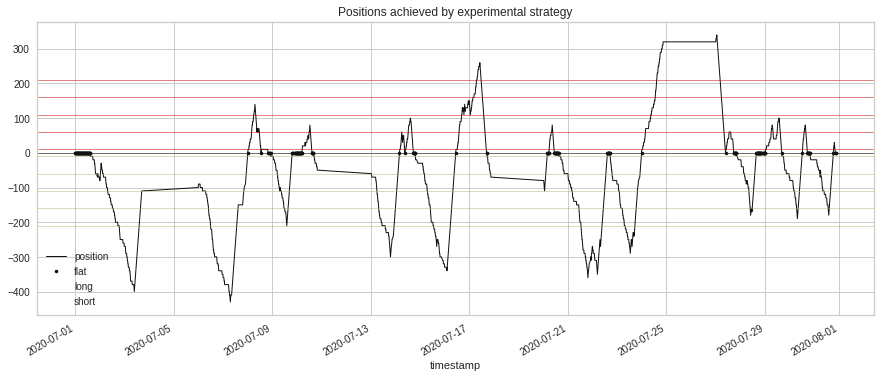

In [64]:
plt.figure(figsize = (15, 6))
data['position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[data.position == 0 ].index, 
         data.position[data.position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[data.position > 1 ].index, 
         data.position[data.position > 1 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[data.position < 1 ].index, 
         data.position[data.position < 1 ], color='green', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')

for i in range(num_stocks_per_trade, num_stocks_per_trade * 25, num_stocks_per_trade * 5 ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range(- num_stocks_per_trade, - num_stocks_per_trade * 25, -num_stocks_per_trade * 5 ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.title('Positions achieved by experimental strategy')
plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

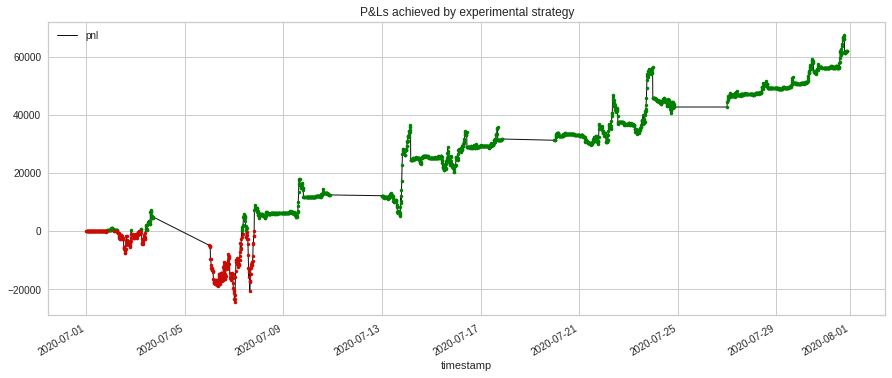

In [65]:
plt.figure(figsize = (15, 6))
data['pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[data.pnl > 1 ].index, data.pnl[data.pnl > 1 ], color='green', lw=0, marker='.')
plt.plot(data.loc[data.pnl < 1 ].index, data.pnl[data.pnl < 1 ], color='r', lw=0, marker='.')
plt.legend()
plt.title('P&Ls achieved by experimental strategy')
plt.show()
